# Extract values to be able to synchronise Miniscope, webcam and ephys

Webcam not synchronised at the moment because there is no conflict between OE_miniscope and miniscope timestamps. 

## Initialize

### Load the required packages (and many more that are not useful)

In [1]:
#%reset
#import sys, os
# add the Contrib dir that contains all tools developped by MB : mbDevTools.py
#sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'Contrib'))
#print(os.path.join(os.path.dirname(sys.path[0]),'Contrib'))

import numpy as np
import csv
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

#import ipywidgets as widgets
#import mbDevTools
from ipyfilechooser import FileChooser

print("the packages are correctly loaded")

the packages are correctly loaded


### Define variables

In [2]:
AcqFre = 20 #it seems to be 20 rahter than 30 based on data 30# frames / sec
delaystampMini = (1000/AcqFre)*1.5
delaystampOE = (25000/AcqFre)*1.5*2

#date = '2022_03_14'
#device = 'MiniscopeCamera'
#time = '13_37_24'

## Import the files

### Define paths

In [3]:
try:
    %store -r folderMouse folder_Ephys folder_sync_messages
except:
    print("data not in strore")
    folderMouse = ""
    folder_Ephys = ""
    folder_sync_messages = ""

fc1 = FileChooser(folderMouse,select_default=True, show_only_dirs = True, title = "<b>Folder with timestamps</b>")
display(fc1)

fc2 = FileChooser(folder_Ephys,select_default=True, show_only_dirs = True, title = "<b>Folder with OpenEphys</b>")
display(fc2)

fc3 = FileChooser(folder_sync_messages,select_default=True, show_only_dirs = True, title = "<b>Folder with syncMessages</b>")
display(fc3)


# Sample callback function
def update_my_folder(chooser):
    global folderMouse, folder_Ephys, folder_sync_messages
    match chooser.title:
        case "<b>Folder with timestamps</b>":
            folderMouse = Path(chooser.selected)
            %store folderMouse
        case "<b>Folder with OpenEphys</b>":
            folder_Ephys = Path(chooser.selected)
            %store folder_Ephys
        case "<b>Folder with syncMessages</b>":
            folder_sync_messages = Path(chooser.selected)
            %store folder_sync_messages
        case _:
            print("something is wierd")
    return 

# Register callback function
fc1.register_callback(update_my_folder)
fc2.register_callback(update_my_folder)
fc3.register_callback(update_my_folder)

FileChooser(path='/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01', filename…

FileChooser(path='/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/recording8', filename='', title='<b>Folder wit…

FileChooser(path='/Users/mb/Documents/Syntuitio/AudreyHay/PlanB', filename='', title='<b>Folder with syncMessa…

In [4]:
print("The folder used for miniscope timestamps is : {}".format(folderMouse))
print("The folder used for OpenEphys data is : {}".format(folder_Ephys))
print("The folder used for sync_messages is : {}".format(folder_sync_messages))

The folder used for miniscope timestamps is : /Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01
The folder used for OpenEphys data is : /Users/mb/Documents/Syntuitio/AudreyHay/PlanB/recording8
The folder used for sync_messages is : /Users/mb/Documents/Syntuitio/AudreyHay/PlanB


### Get timestamps

In [5]:
for file_path in folderMouse.glob('**/*timeStamps.csv'):
    subfolder = file_path.parents[0].stem
    if 'V4_Miniscope' in subfolder:
        stamps_miniscope = pd.read_csv(file_path)
    elif 'WebCam' in subfolder:
        stamps_webcam = pd.read_csv(file_path)

### Get OpenEphys files

In [6]:
# Warning, here I a have moved the OpenEphys file to the video folder. To determine what is the most efficient strategy
for file_path in folder_Ephys.glob('**/timestamps.npy'):#*.npy'):
    subfolder = file_path.parents[0].stem
    if 'TTL' in subfolder:
        file = file_path.stem
        stamps_OEmini = np.load(file_path)
        datalen = len(stamps_OEmini)
        coords = {
            'recordings' : np.array(['full_words', 'timestamps', 'channel_states', 'channels']),
            'duration_rec' : np.arange(datalen)
        }
        Allstamps = xr.DataArray(coords=coords, dims=['recordings', 'duration_rec']) 


for file_path in folder_Ephys.glob('**/*.npy'):
    subfolder = file_path.parents[0].stem
    if 'TTL' in subfolder:
        file = file_path.stem
        stamps_OEmini = np.load(file_path)
        Allstamps.loc[file,:] = stamps_OEmini

print(Allstamps)


<xarray.DataArray (recordings: 4, duration_rec: 18646)>
array([[ 3.00000000e+00,  2.00000000e+00,  3.00000000e+00, ...,
         2.00000000e+00,  3.00000000e+00,  2.00000000e+00],
       [ 2.53318850e+08,  2.53321351e+08,  2.53343850e+08, ...,
         2.76698339e+08,  2.76720838e+08,  2.76723339e+08],
       [ 1.00000000e+00, -1.00000000e+00,  1.00000000e+00, ...,
        -1.00000000e+00,  1.00000000e+00, -1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00]])
Coordinates:
  * recordings    (recordings) <U14 'full_words' 'timestamps' ... 'channels'
  * duration_rec  (duration_rec) int64 0 1 2 3 4 ... 18642 18643 18644 18645


## Clean data

### Plot the different timestamps files
Not a necessary step unless there is doubt about the data quality

range(0, 18646)


Text(0.5, 1.0, 'channels')

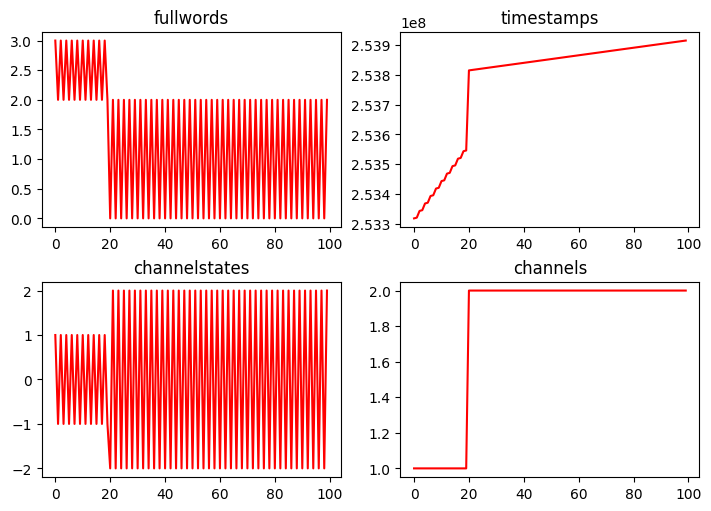

In [7]:
time = range(datalen)
print(time)
fullwords = Allstamps.loc['full_words',:].values
timestamps = Allstamps.loc['timestamps',:].values
channelstates = Allstamps.loc['channel_states',:]
channels = Allstamps.loc['channels',:]

debut = 0
fin = 100
timeTrunc = time[debut:fin]
fullwordsTrunc = fullwords[debut:fin]
timestampsTrunc = timestamps[debut:fin]
channelstatesTrunc = channelstates[debut:fin]
channelsTrunc = channels[debut:fin]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(7,5), layout='constrained') 
ax1.plot(timeTrunc, fullwordsTrunc, 'r')
ax2.plot(timeTrunc, timestampsTrunc, 'r')
ax3.plot(timeTrunc, channelstatesTrunc, 'r')
ax4.plot(timeTrunc, channelsTrunc, 'r')

ax1.set_title('fullwords')
ax2.set_title('timestamps')
ax3.set_title('channelstates')
ax4.set_title('channels')


### Crop experiment?

not sure yet

### Detect frame drops

Compute the delta between each time stamp in the miniscope timestamp file, this allows for determining if and when a frame was dropped.

In [8]:
stamps_miniscope_time = stamps_miniscope['Time Stamp (ms)']
delay_stamps = []
dropped_frames = []
number_frames = stamps_miniscope['Time Stamp (ms)'].count()
for i in range(number_frames -1):
    delay_stamps.append(stamps_miniscope_time[i+1] - stamps_miniscope_time[i])
    if delay_stamps[i] > delaystampMini:
        dropped_frames.append(i)

#plt.plot(delay_stamps)
print("the calculated frame rate is : {}".format(1/(sum(delay_stamps) / len(delay_stamps))) )

freq_acq = round(1000/(sum(delay_stamps)/len(delay_stamps)))
print("{} frame(s) were dropped : {}".format(len(dropped_frames),dropped_frames))


the calculated frame rate is : 0.019758040069446356
1 frame(s) were dropped : [17881]


### Laser and miniscope timestamps extraction
From the xarray that summarises all the timestamps (laser and miniscope) received as TTL by OpenEphys, we extract the timestamps that correspond to either laser or miniscope.

In [9]:
OE_stamps_miniscope = []
OE_stamps_laser = []

for i in range(datalen):
    if channels[i] == 2:
        OE_stamps_miniscope.append(timestamps[i])
    elif channels[i] == 1:
        OE_stamps_laser.append(timestamps[i])

len(OE_stamps_miniscope)

17926

Plot to make sure the right stamps have been rightly distributed to the appropriate list.

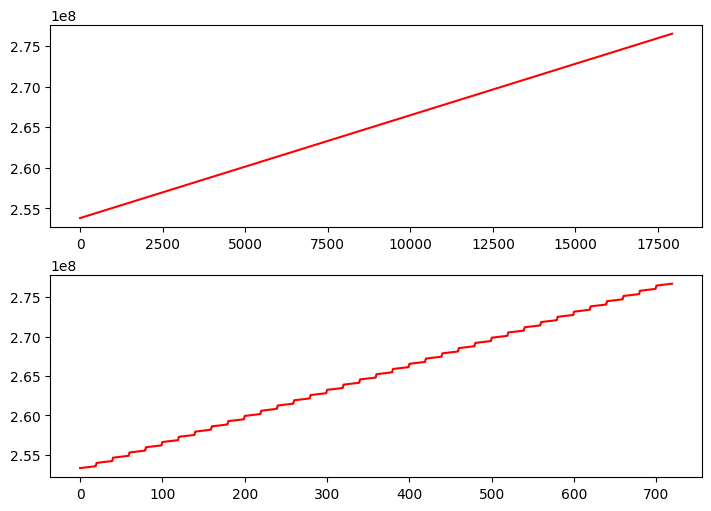

In [10]:
time1 = range(len(OE_stamps_miniscope))
time2 = range(len(OE_stamps_laser))

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,5), layout='constrained') 
ax1.plot(time1, OE_stamps_miniscope, 'r')
ax2.plot(time2, OE_stamps_laser, 'r')

Determine if I can see dropped frames in OE

In [11]:
time1 = range(len(OE_stamps_miniscope)-2)
delay_stamps = []
for i in time1:
    delay_stamps.append(OE_stamps_miniscope[i+2] - OE_stamps_miniscope[i])
    if delay_stamps[i] > delaystampOE:
        print(delay_stamps[i], i)



3791.0 17878
3792.0 17879


### Normalise time stamps from open ephys signal

two steps
- remove initial timing by extracting software 0ing from .txt file
- to get time in ms and not in acquisition point (acq rate = 25 kHz)
- for laser, get one value per laser flash

In [12]:
A = []
print("looking for sync_messages.txt in folder : {}".format(folder_sync_messages))
for file_path in folder_sync_messages.glob('**/*sync_messages.txt'):
    with open(file_path, "r") as f:
        lines = f.readlines()
    # Loop through all lines, ignoring header.
    # take last element to list (i.e. the process name)
        for l in lines[1:]:
            A.append(l.split()[-1])
print("it reads {}".format(A))

# remove acquisition frequency that is normally always 25 kHz
initial_OE_start = int(' '.join([x.split('@')[0] for x in A]))#int(''.join([x.strip('@25000Hz') for x in A]))
acqFreqOE = int(' '.join([x[:-2].split('@')[1] for x in A]))
#initial_OE_start = 411044352#stamps_OEOE[0]
# transform in pd series for easier manipulation
B = pd.Series(OE_stamps_miniscope)
C = pd.Series(OE_stamps_laser)

# normalise to ms
OE_stamps_miniscope_n = (B - initial_OE_start)/acqFreqOE#25000
OE_stamps_laser_inter = (C - initial_OE_start)/acqFreqOE#25000

# take only the middle of the laser pulse
OE_stamps_laser_n = [] 
for i in range(len(OE_stamps_laser_n) - 1):
    if (OE_stamps_laser_n[i+1] - OE_stamps_laser_n[i]) < 30:
        interm = OE_stamps_laser_n[i] + 10
        OE_stamps_laser_n.append(interm)


looking for sync_messages.txt in folder : /Users/mb/Documents/Syntuitio/AudreyHay/PlanB
it reads ['253298944@25000Hz']


Last, extract important values for the next steps
- start acquisition time for Ca2+ relative to OE internal time and to time zeroed.
- acquisition frequency for Ca2+ imaging
- dropped frame timing

In [13]:
# _n is from 0
acquisition_mini_start_n = OE_stamps_miniscope_n[0]
# _a is from acquisition time software
acquisition_mini_start_a = B[0]
# freq_acq in Hz
freq_acq
# list of dropped frames from miniscope
dropped_frames

outSumm = pd.Series([acquisition_mini_start_n, acquisition_mini_start_a, freq_acq, dropped_frames],
              index=['Miniscope start from 0', 'Miniscope start from Acq time soft', 'mini acq freq', 'dropped frames'])


filenameOut = folderMouse / f'SynchroFile.xlsx'
writer = pd.ExcelWriter(filenameOut)
outSumm.to_excel(writer)
writer.close()

        

In [14]:
outSumm

Miniscope start from 0                   20.62732
Miniscope start from Acq time soft    253814627.0
mini acq freq                                  20
dropped frames                            [17881]
dtype: object